# cMetrics Visualizer
Choose any number of containers ($n$) and any number of stats ($m$) that you want to see. The visualizer will display $m$ plots  with $n$ lines each, represeting your choice. Use `SHIFT` or `CMD` to select multiple items, then press `GET GRAPHS`.

Run All to begin.

Ignore the Widget Javascript warning. That's a known, outstanding bug with ipywidgets.


In [1]:
from IPython.display import HTML
from __future__ import print_function

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import style
import redis
from datetime import datetime
import ipywidgets as widgets
import json
import os
import sys
import time
import numpy as np
from IPython.display import display

# Sets some default variables
HOST = "127.0.0.1"
PORT = 6379
stat_names = {"Time": "timestamp", "CPU Load": "cpu_load", "CPU Usage": "cpu_usage", "RX Bytes": "network_rx", "TX Bytes": "network_tx", "Memory Usage": "memory", "Read KB": "disk_read", "Write KB": "disk_write"}
inv_stat_names = {v: k for k, v in stat_names.items()}
style.use("ggplot")

# Sets up redis interface
r = redis.StrictRedis(host=HOST, port=PORT)

In [3]:
# Adds an item to a list, and removes the 0th item if the new size > trange
def append(arr, item):
    if len(arr) >= trange:
        arr.pop(0)
    arr.append(item)

# Cycles through the default color set and increments the index
def cycle(i):
    color = "brgcmykw"
    if i  == 8:
        i = -1
    i += 1
    return color[i], i

# Updates each stat's list for each container 
def updateEach(name, jsn):
    
    # Does not update if the json object is the same as most recent added
    if len(name["timestamp"]) > 0 and jsn["ts"] == name["timestamp"][-1].strftime("%X"):
        return
    
    # Retrieves the info from the json object and calls append
    append(name["cpu_load"], jsn["cpu"]["load"]["ave"])
    append(name["cpu_usage"], jsn["cpu"]["usage"])
    append(name["network_rx"], jsn["network"]["rx_kb"])
    append(name["network_tx"], jsn["network"]["tx_kb"])
    append(name["memory"], jsn["memory"]["ave"])
    append(name["disk_read"], jsn["diskio"]["read"])
    append(name["disk_write"], jsn["diskio"]["write"])
    append(name["timestamp"], datetime.strptime(jsn["ts"], "%X"))

# Creates the graphs and sets up the animation
def plotme(containers, stats):
    # All the entries for each container
    entries = {}
    # All the plots created. Once for each stat
    figs = {}    
    
    # Updates the last TRANGE entries for each contrainer
    for name in containers:
        entries[name] = {}
        last20 = r.lrange(name, 0, trange-1)[::-1]
        for s in stat_names.values():
            entries[name][s] = []
        for e in last20:
            updateEach(entries[name], json.loads(e))
            
    # Creates and plots the starting data for each graph
    for stat in stats:
        f = plt.figure(num=inv_stat_names[stat], figsize=(9, 5))
        ax = f.add_subplot(1,1,1)
        i = 0
        for name in containers:
            color, i = cycle(i)
            ax.plot(entries[name]["timestamp"], entries[name][stat], color=color, label=name)    
        ax.set_xlabel("Time")
        ax.set_ylabel(inv_stat_names[stat])
        box = ax.get_position()
        ax.legend(ncol=2, loc='upper center', bbox_to_anchor=[0.5, 1.1])        
        figs[stat] = [f,ax]
    
    # Updates the entries and redraws all the plots
    def animate():
        for name in containers:
            updateEach(entries[name], json.loads(r.lindex(name, 0)))            
        for stat in stats:
            f  = figs[stat][0]
            ax = figs[stat][1]
            ax.clear()
            i = 0
            for name in containers:
                color, i = cycle(i)
                ax.plot(entries[name]["timestamp"], entries[name][stat], color=color, label=name)   
            ax.set_xlabel("Time")
            ax.set_ylabel(inv_stat_names[stat])
            ax.legend(ncol=2, loc='upper center', bbox_to_anchor=[0.5, 1.1])        
            f.canvas.draw()
    
    # Set to animate once per second
    while True:
        animate()
        time.sleep(1)

Widget Javascript not detected.  It may not be installed or enabled properly.


<IPython.core.display.Javascript object>


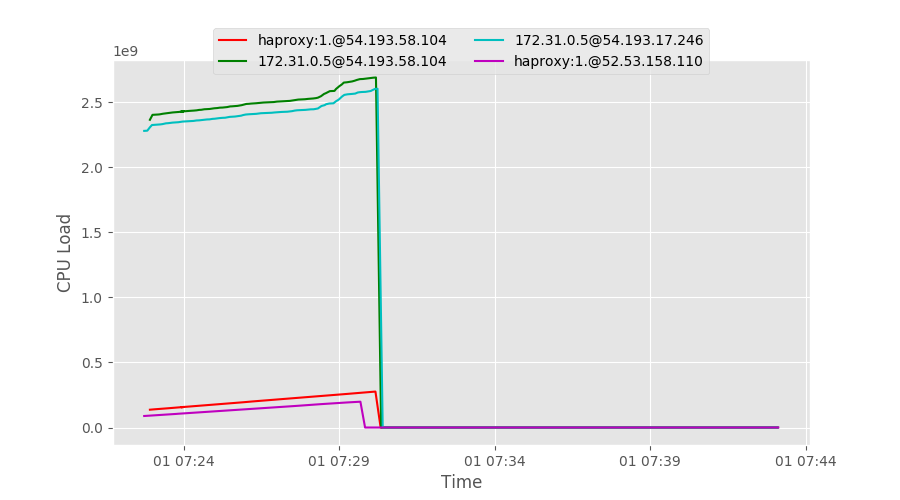

<IPython.core.display.Javascript object>


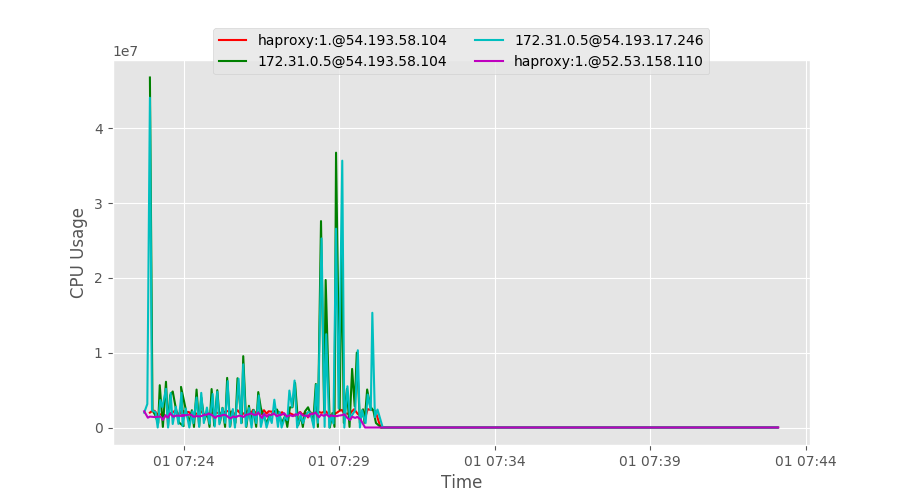

In [4]:
# The list of all container names
all_containers = [x.decode('utf-8') for x in list(r.smembers("names"))]

# Allows the user to choose which contaienrs to plot
cont1 = widgets.SelectMultiple(
    options=all_containers,
    layout=widgets.Layout(display="flex", flex_flow='column'),
    description='Choose Containers',
    disabled=False
)

# Allows the user to choose which stats to plot
cont2 = widgets.SelectMultiple(
    options=stat_names,
    layout=widgets.Layout(display="flex", flex_flow='column'),
    description='Choose Stats',
    disabled=False
)

# Allows the user to set the time range of the plots
time_range = widgets.IntText(
    value=7,
    description='Minutes:',
    disabled=False,
    width=50
)

# Submits the users's choices and starts the plots
submit = widgets.Button(
    description='See Live',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='See Live',
    icon='check'
)


boc = widgets.HBox([cont1, cont2, widgets.VBox([time_range, submit])])
display(boc)
names = []
stats = []
trange = 2

# Action called by the submit button
def on_button_clicked(b):
    del names[:]
    del stats[:]
    global trange
    trange = time_range.value * 12
    names.extend(list(cont1.value))
    stats.extend(list(cont2.value))
    plotme(names, stats)

submit.on_click(on_button_clicked)
